In [27]:
import numpy as np
from sklearn.model_selection import train_test_split

In [28]:
import os
from PIL import Image

def load_yale_faces(data_dir, image_size=(64, 64)):
  image_data = []
  labels = []
  formats = ('.glasses', '.wink', '.sleepy', '.sad',
                    '.centerlight', '.happy', '.normal',
                    '.surprised', '.leftlight', '.rightlight',
                    '.noglasses')

  i = -1
  for img_name in os.listdir(data_dir):
    img_path = os.path.join(data_dir, img_name)
    i += 1
    if img_path.lower().endswith(formats):
      img = Image.open(img_path).convert('RGB')

      if i == 0:
        print(img)

      img = img.resize(image_size)

      if i == 0:
        print(img)

      img_array = np.array(img)

      if i == 0:
        print(img_array.shape)

      image_data.append(img_array)
      label = img_name.split('.')[0]
      labels.append(label)

  image_matrix = np.array(image_data)
  labels = np.array(labels)

  return image_matrix, labels

X, y = load_yale_faces('/content/drive/MyDrive/ML_Self/data', image_size=(64, 64))
X_flattened = X.reshape(X.shape[0], -1)
# X

<PIL.Image.Image image mode=RGB size=320x243 at 0x798F0B542D70>
<PIL.Image.Image image mode=RGB size=64x64 at 0x798F0B540340>
(64, 64, 3)


In [29]:
X_flattened.shape

(165, 12288)

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X_flattened, y, test_size=0.2, random_state=42)

In [31]:
# print(X_train[0].shape)
# for i in range(X_train.shape[0]):
#   print(X_train[0][i])

In [32]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [33]:
# print(X_train_scaled[0].shape)
# for i in range(X_train_scaled.shape[0]):
#   print(X_train_scaled[0][i])

In [34]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(max_depth=10, random_state=42)
dt.fit(X_train_scaled, y_train)

DecisionTreeClassifier(max_depth=10, random_state=42)

In [35]:
from sklearn.metrics import accuracy_score, classification_report

y_pred = dt.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: ", accuracy)
# print(classification_report(y_test, y_pred))

Accuracy:  0.5151515151515151


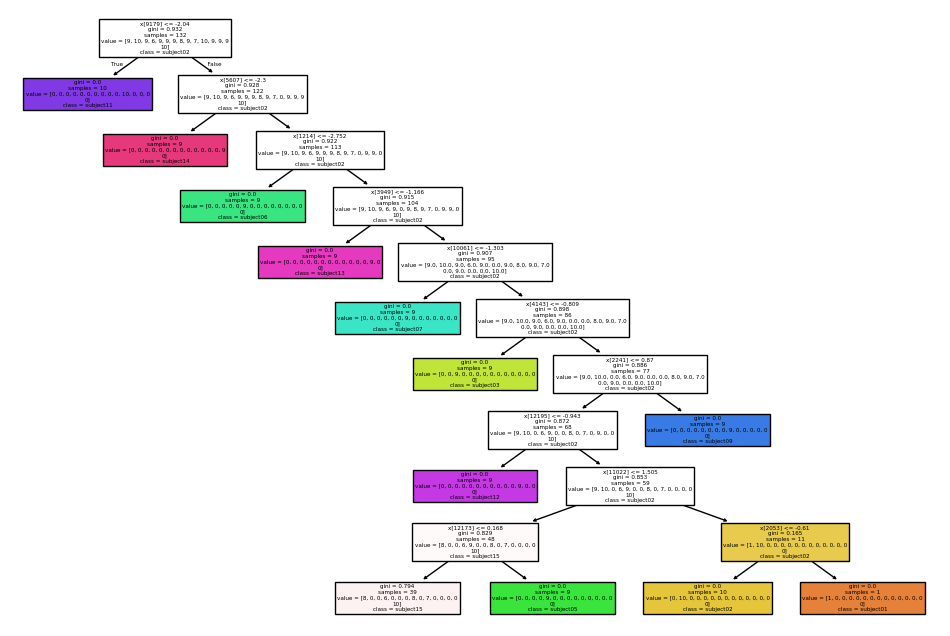

In [36]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

plt.figure(figsize=(12, 8))
plot_tree(dt, filled=True, class_names=[str(i) for i in np.unique(y)])
plt.show()


In [38]:
import numpy as np
from collections import Counter

class DecisionTreeNode:
    def __init__(self, feature=None, threshold=None, left=None, right=None, output=None):
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right
        self.output = output

class DecisionTree:
    def __init__(self, min_samples_split=2, max_depth=None):
        self.root = None
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        self.depth = 0

    def fit(self, X, y):
        self.root = self._build_tree(X, y, depth=0)

    def _build_tree(self, X, y, depth):

        if self.depth is None:
          self.depth = depth
        else:
          self.depth = max(self.depth, depth)

        if len(set(y)) == 1:
            return DecisionTreeNode(output=y[0])

        if len(y) < self.min_samples_split:
            return DecisionTreeNode(output=Counter(y).most_common(1)[0][0])

        if self.max_depth is not None and depth >= self.max_depth:
            return DecisionTreeNode(output=Counter(y).most_common(1)[0][0])

        num_features = X.shape[1]
        best_feature, best_threshold = self._best_split(X, y, num_features)

        if best_feature is None:
            return DecisionTreeNode(output=Counter(y).most_common(1)[0][0])

        left_indices = X[:, best_feature] <= best_threshold
        right_indices = X[:, best_feature] > best_threshold

        left_subtree = self._build_tree(X[left_indices], y[left_indices], depth + 1)
        right_subtree = self._build_tree(X[right_indices], y[right_indices], depth + 1)

        return DecisionTreeNode(best_feature, best_threshold, left_subtree, right_subtree)

    def _best_split(self, X, y, num_features):
        best_gain = -1
        best_feature = None
        best_threshold = None

        for feature in range(num_features):
            thresholds = np.unique(X[:, feature])
            for threshold in thresholds:
                gain = self._information_gain(X, y, feature, threshold)
                if gain > best_gain:
                    best_gain = gain
                    best_feature = feature
                    best_threshold = threshold

        return best_feature, best_threshold

    def _information_gain(self, X, y, feature, threshold):
        parent_entropy = self._entropy(y)

        left_indices = X[:, feature] <= threshold
        right_indices = X[:, feature] > threshold

        if len(y[left_indices]) == 0 or len(y[right_indices]) == 0:
            return 0

        n = len(y)
        n_left = len(y[left_indices])
        n_right = len(y[right_indices])

        child_entropy = (n_left / n) * self._entropy(y[left_indices]) + (n_right / n) * self._entropy(y[right_indices])

        return parent_entropy - child_entropy

    def _entropy(self, y):
        counts = Counter(y)
        total = len(y)
        return -sum((count / total) * np.log2(count / total) for count in counts.values() if count > 0)

    def predict(self, X):
        return np.array([self._predict_sample(sample, self.root) for sample in X])

    def _predict_sample(self, sample, node):
        if node.output is not None:
            return node.output
        if sample[node.feature] <= node.threshold:
            return self._predict_sample(sample, node.left)
        else:
            return self._predict_sample(sample, node.right)

In [39]:
dt = DecisionTree()
dt.fit(X_train, y_train)

In [40]:
y_pred = dt.predict(X_test)
accuracy = np.sum(y_pred == y_test) / len(y_test)
print("Accuracy: ", accuracy)

Accuracy:  0.6666666666666666


In [41]:
print(dt.depth)

6


In [42]:
dt = DecisionTree(max_depth=2)
dt.fit(X_train, y_train)

y_pred = dt.predict(X_test)
accuracy = np.sum(y_pred == y_test) / len(y_test)
print("Accuracy: ", accuracy)
print(dt.depth)

Accuracy:  0.18181818181818182
2


In [43]:
dt = DecisionTree(max_depth=3)
dt.fit(X_train, y_train)

y_pred = dt.predict(X_test)
accuracy = np.sum(y_pred == y_test) / len(y_test)
print("Accuracy: ", accuracy)
print(dt.depth)

Accuracy:  0.30303030303030304
3


In [44]:
dt = DecisionTree(max_depth=4)
dt.fit(X_train, y_train)

y_pred = dt.predict(X_test)
accuracy = np.sum(y_pred == y_test) / len(y_test)
print("Accuracy: ", accuracy)
print(dt.depth)

Accuracy:  0.5757575757575758
4


In [45]:
dt = DecisionTree(max_depth=5)
dt.fit(X_train, y_train)

y_pred = dt.predict(X_test)
accuracy = np.sum(y_pred == y_test) / len(y_test)
print("Accuracy: ", accuracy)
print(dt.depth)

Accuracy:  0.6363636363636364
5
